In [5]:
import pennylane as qml
import numpy as np
import jax
import matplotlib.pyplot as plt
import pickle
import os
import matplotlib.pyplot as plt


In [6]:
from two_qubit_decomp_to_su4 import *


In [7]:
def get_hamiltonian_n_site_terms(n, coeff, n_qubits):
    XX_coeff = coeff[0]
    YY_coeff = coeff[1]
    ZZ_coeff = coeff[2]
    Z_coeff = coeff[3]
    return (SparsePauliOp(("I" * n + "XX" + "I" * (n_qubits - 2 - n))) * XX_coeff + 
            SparsePauliOp(("I" * n + "YY" + "I" * (n_qubits - 2 - n))) * YY_coeff + 
            SparsePauliOp(("I" * n + "ZZ" + "I" * (n_qubits - 2 - n))) * ZZ_coeff + 
            SparsePauliOp(("I" * n + "Z" + "I" * (n_qubits - 1 - n))) * Z_coeff)
coeff = [0,1,2,3]
# get_hamiltonian_n_site_terms(1,coeff,4)

In [8]:
def get_heisenberg_hamiltonian(n_qubits, coeff=None):
    # Three qubits because for 2 we get H_O = 0
    assert n_qubits >= 3

    if coeff == None:
        coeff = [[1.0, 1.0, 1.0, 1.0] for i in range(n_qubits)]

    # Even terms of the Hamiltonian (summing over individual pair-wise elements)
    H_E = sum((get_hamiltonian_n_site_terms(i, coeff[i], n_qubits) 
               for i in range(0, n_qubits - 1, 2)))

    # Odd terms of the Hamiltonian (summing over individual pair-wise elements)
    H_O = sum((get_hamiltonian_n_site_terms(i, coeff[i], n_qubits) 
               for i in range(1, n_qubits - 1, 2)))

    # adding final Z term at the Nth site
    if (n_qubits % 2) == 0:
        H_E += SparsePauliOp(("I" * (n_qubits - 1) + "Z")) * coeff[n_qubits - 1][3]
    else:
        H_O += SparsePauliOp(("I" * (n_qubits - 1) + "Z")) * coeff[n_qubits - 1][3]

    return [H_E, H_O]

get_heisenberg_hamiltonian(6)

[SparsePauliOp(['XXIIII', 'YYIIII', 'ZZIIII', 'ZIIIII', 'IIXXII', 'IIYYII', 'IIZZII', 'IIZIII', 'IIIIXX', 'IIIIYY', 'IIIIZZ', 'IIIIZI', 'IIIIIZ'],
               coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
  1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]),
 SparsePauliOp(['IXXIII', 'IYYIII', 'IZZIII', 'IZIIII', 'IIIXXI', 'IIIYYI', 'IIIZZI', 'IIIZII'],
               coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])]

##ZZ Hamiltonian(Bhanushali Version)

In [9]:
def create_longitudinal_ising_hamiltonian(num_wires: int, J: float = 1.0, hx: float = 0.5, hz: float = 0.5):
    coeffs = []
    obs = []

    # ZZ interactions
    for i in range(num_wires):
        for j in range(i + 1, num_wires):
            coeffs.append(-J)
            obs.append(qml.PauliZ(i) @ qml.PauliZ(j))

    # X interactions (transverse field)
    for i in range(num_wires):
        coeffs.append(-hx)
        obs.append(qml.PauliX(i))
    
    # Z interactions (longitudinal field)
    for i in range(num_wires):
        coeffs.append(-hz)
        obs.append(qml.PauliZ(i))

    hamiltonian = qml.Hamiltonian(coeffs, obs)
    e_min = min(qml.eigvals(hamiltonian))
    return hamiltonian.matrix()
num_wires = 4
wires = list(range(num_wires))
hulu = create_longitudinal_ising_hamiltonian(num_wires)
hulu
# H_matrix = hulu.to_matrix()
H = qml.Hermitian(hulu,wires)
# H_matrix
H
E_min = min(qml.eigvals(H))
print(f"Ground state energy: {E_min:.5f}")

Ground state energy: -8.14301


In [10]:
from qiskit.quantum_info import SparsePauliOp

num_wires = 6
wires = list(range(num_wires))
np.random.seed(62213)

# Define the Hamiltonian
hamiltonian = get_heisenberg_hamiltonian(num_wires)[0] - get_heisenberg_hamiltonian(num_wires)[1]
# hamiltonian = SparsePauliOp.from_list([
#     ("IIZZ", 1), ("ZIZI", 1), ("IZZI", 1), ("ZIIZ", 1), ("ZZII", 1)
# ])

# Convert the SparsePauliOp to a matrix
H_matrix = hamiltonian.to_matrix()
H = qml.Hermitian(H_matrix, wires=wires)

# Compute the eigenvalues and eigenvectors of the Hamiltonian

E_min_noisy = min(qml.eigvals(H))

# eigenvalues, eigenvectors = np.linalg.eigh(H_matrix)
# eigenvalues



In [11]:
def two_qubit_decomp_1(params, wires):
    """Implement an arbitrary SU(4) gate on two qubits
    using the decomposition from Theorem 5 in
    https://arxiv.org/pdf/quant-ph/0308006.pdf"""
    
    i, j = wires    
    qml.RZ(params[0], wires=i)
    qml.RY(params[1], wires=i)
    qml.RZ(params[2], wires=i)
    qml.RZ(params[3], wires=j)
    qml.RY(params[4], wires=j)
    qml.RZ(params[5], wires=j)
    qml.CNOT(wires=[j, i])
    qml.RZ(params[6], wires=i)
    qml.RY(params[7], wires=j)
    qml.CNOT(wires=[i, j])
    qml.RY(params[8], wires=j)
    qml.CNOT(wires=[j, i])
    qml.RZ(params[9], wires=j)
    qml.RY(params[10], wires=j)
    qml.RZ(params[11], wires=j)
    qml.RZ(params[12], wires=i)
    qml.RY(params[13], wires=i)
    qml.RZ(params[14], wires=i)

In [12]:
# Initialize parameters for different circuit repetitions
loc = 2  # Local dimension for two-qubit operations
d = loc**4 - 1  # Number of parameters for two-qubit operations (15 for SU(4))

repetitions = [2,4,6,8,10]
param_shapes = [(rep, 2, 2, d) for rep in repetitions]


def create_params_decomp_su4(init_params_list):
    init_params_list1 = [np.zeros(shape) for shape in param_shapes]
    for rep_index,init_params in enumerate(init_params_list):
        for block_idx, params_block in enumerate(init_params):
            for layer_idx, params_layer in enumerate(params_block):
                for op_idx, params_op in enumerate(params_layer):
                    # Update the element in the original list
                    init_params_list1[rep_index][block_idx][layer_idx][op_idx] = rev_map(params_op)

    return init_params_list1



In [13]:
#num_wires = 4  # Number of qubits

dev = qml.device("default.qubit", wires=num_wires)

# Initialize parameters for different circuit repetitions
repetitions = [2,4,6,8,10]
param_shapes = [(rep, 2, 3, d) for rep in repetitions]

init_params_list = [np.random.randn(*shape) for shape in param_shapes] # give same initial parameters for each repetitions

#init_params_list = [np.zeros(shape) for shape in param_shapes] # give same initial parameters for each repetitions

#Near-Identity Initialization

# Define the small random noise to be added to each element
epsilon = 1e-2  # This defines the magnitude of the random noise

# Create the initial parameters list with small random noise added to each element
#init_params_list = [np.zeros(shape) + epsilon * np.random.randn(*shape) for shape in param_shapes]

init_params_list1 = create_params_decomp_su4(init_params_list)




C:\Users\DELL\AppData\Local\Temp\ipykernel_55488\1174667161.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  init_params_list1[rep_index][block_idx][layer_idx][op_idx] = rev_map(params_op)


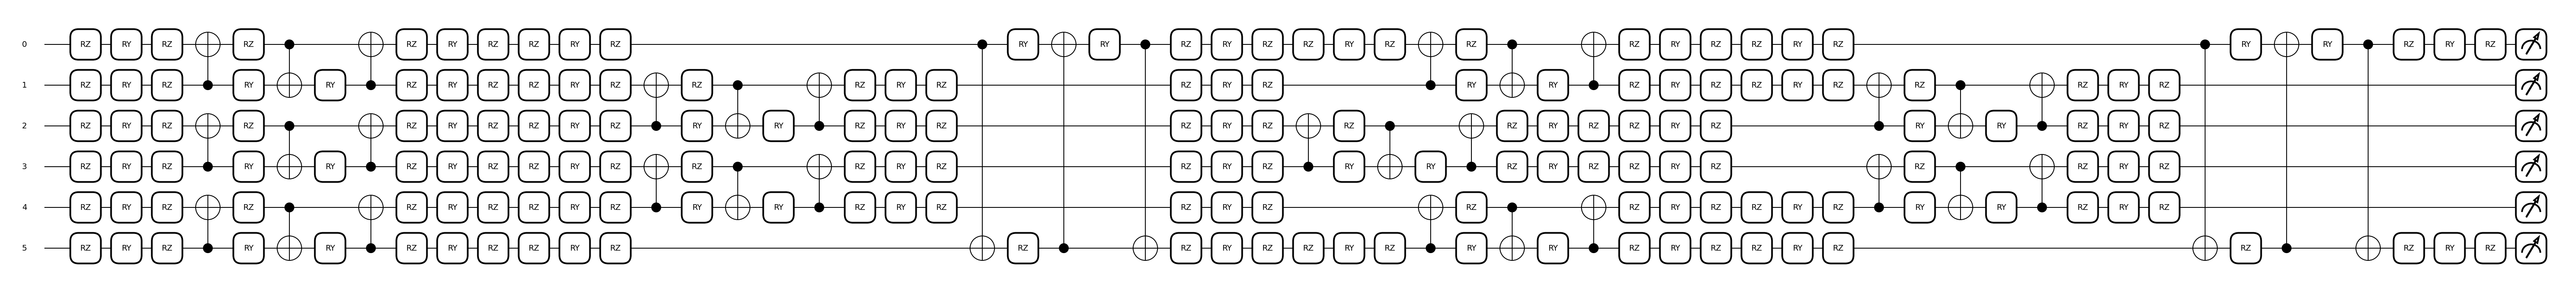

In [9]:

# Define the quantum circuit function
def circuit(params, operation=None):
    """Apply an operation in a brickwall-like pattern to a qubit register and measure H.
    Parameters are assumed to have the dimensions (number of blocks, number of
    wires per operation, number of operations per layer, and number of parameters
    per operation), in that order.
    """
    for params_block in params:
        for i, params_layer in enumerate(params_block):
            for j, params_op in enumerate(params_layer):
                wires_op = [w % num_wires for w in range(loc * j + i, loc * (j + 1) + i)]
                #wires_op = [(loc * j + i + w) % num_wires for w in range(loc)]
                operation(params_op, wires_op)
    return qml.expval(H)

# Create QNodes for different circuit repetitions
qnodes = [qml.QNode(circuit, dev, interface="jax") for _ in repetitions]


# Drawing the last QNode with the last set of initial parameters using SpecialUnitary
fig, ax = qml.draw_mpl(qnodes[0])(init_params_list[0], two_qubit_decomp_1)

# Display the circuit
plt.show()

In [10]:
learning_rate = 5e-4
num_steps = 1000
#grad_fn = jax.jit(jax.jacobian(qnode), static_argnums=1)

# Define a function to run optimization for each circuit repetition
def optimize(i, operation): # i stands for repetition index
    # Select the appropriate initial parameters list
    if operation == two_qubit_decomp_1:
        params = init_params_list[i]
    else:
        params = init_params_list1[i]
    grad_fn = jax.jit(jax.jacobian(qnodes[i]), static_argnums=1)
    energies = []
    #params = init_params_list[i]
    #qnode
    for step in range(num_steps):
        cost = qnodes[i](params,operation)
        params = params - learning_rate * grad_fn(params, operation)
        energies.append(cost)
    energies.append(cost)
    return energies



In [12]:
def calculate_errors(repetitions,operation, E_min):

    """
    Calculate the relative errors for a set of circuit repetitions and save them to a file.

    Parameters:
    repetitions (list): List of circuit repetitions.
    operation (qml.Operation): The quantum operation to be used.
    E_min (float): The minimum energy value to compute the relative error.

    Returns:
    dict: A dictionary with repetitions as keys and relative error arrays as values.
    """

    # Initialize the error dictionary
    error_dict = {}

    for i, rep in enumerate(repetitions):
        # Calculate the energy values
        e = optimize(i, operation)
        
        # Compute the relative error
        error = (e - E_min) / abs(E_min)
        
        # Store the errors in the dictionary
        error_dict[rep] = error

    # Example details
    hamiltonian_info = "heisenberg_hamiltonian"

    operation_info = 'SU' if operation == qml.SpecialUnitary else '2_Qub_Decomp'

    num_qubits = num_wires
    param_info = 'rand_mapped'

    # Construct the filename
    filename = f"{hamiltonian_info}_{operation_info}_{num_qubits}_{param_info}.pkl"

    # Define the folder where you want to save the file
    folder_path ="C:/Users/cclab1/Downloads/SUN-circuits/SUN-circuits/Graphs/Plot_Data"
    # Replace with your folder path
    # Ensure the folder exists
    os.makedirs(folder_path, 
                exist_ok=True)

    file_path = os.path.join(folder_path, 
                             filename)

    # # # Save the dictionary to the specified folder with the constructed filename
    try:
        # Save the dictionary to the specified folder with the constructed filename
        with open(file_path, 'wb') as f:
            pickle.dump(error_dict, f)
        print(f"Dictionary successfully saved to {file_path}")
    except Exception as e:
        print(f"An error occurred while saving the dictionary: {e}")
    return error_dict

calculate_errors(repetitions,two_qubit_decomp_1,E_min_noisy)
calculate_errors(repetitions,qml.SpecialUnitary,E_min_noisy)



<>:40: SyntaxWarning: invalid escape sequence '\P'
<>:40: SyntaxWarning: invalid escape sequence '\P'
C:\Users\cclab1\AppData\Local\Temp\ipykernel_85700\1051747063.py:40: SyntaxWarning: invalid escape sequence '\P'
  folder_path ="C:/Users/cclab1/Downloads/SUN-circuits/SUN-circuits/Graphs\Plot_Data"
c:\Python312\Lib\site-packages\pennylane\math\utils.py:228: UserWarning: Contains tensors of types {'jax', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
c:\Python312\Lib\site-packages\pennylane\math\utils.py:228: UserWarning: Contains tensors of types {'jax', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
c:\Python312\Lib\site-packages\pennylane\math\utils.py:228: UserWarning: Contains tensors of types {'jax', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd.

Dictionary successfully saved to C:/Users/cclab1/Downloads/SUN-circuits/SUN-circuits/Graphs\Plot_Data\heisenberg_hamiltonian_2_Qub_Decomp_6_rand_mapped.pkl


c:\Python312\Lib\site-packages\jax\_src\lax\lax.py:2785: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
c:\Python312\Lib\site-packages\jax\_src\lax\lax.py:2785: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
c:\Python312\Lib\site-packages\jax\_src\lax\lax.py:2785: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
c:\Python312\Lib\site-packages\jax\_src\lax\lax.py:2785: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
c:\Python312\Lib\site-packages\jax\_src\lax\lax.py:2785: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.a

Dictionary successfully saved to C:/Users/cclab1/Downloads/SUN-circuits/SUN-circuits/Graphs\Plot_Data\heisenberg_hamiltonian_SU_6_rand_mapped.pkl


{2: array([1.0241189 , 1.0184399 , 1.012782  , ..., 0.14814827, 0.14799137,
        0.14799137], dtype=float32),
 4: array([0.94530773, 0.9389675 , 0.9326433 , ..., 0.00706611, 0.00705033,
        0.00705033], dtype=float32),
 6: array([9.7283393e-01, 9.6507698e-01, 9.5731109e-01, ..., 1.9804598e-04,
        1.9786971e-04, 1.9786971e-04], dtype=float32),
 8: array([9.9109137e-01, 9.7804415e-01, 9.6494800e-01, ..., 7.5357952e-05,
        7.5357952e-05, 7.5357952e-05], dtype=float32),
 10: array([ 9.2663378e-01,  9.1001105e-01,  8.9340991e-01, ...,
        -8.8137952e-08,  1.2339314e-06,  1.2339314e-06], dtype=float32)}

In [15]:
# Load the Dictionary

file_path_1 ='C:/Users/cclab1/Downloads/SUN-circuits/SUN-circuits/Graphs/Plot_Data/heisenberg_hamiltonian_SU_6_rand_mapped.pkl'
file_path_2 = 'C:/Users/cclab1/Downloads/SUN-circuits/SUN-circuits/Graphs/Plot_Data/heisenberg_hamiltonian_2_Qub_Decomp_6_rand_mapped.pkl'
# Loading the dictionary (for reference)

# Loading the dictionaries
with open(file_path_1, 'rb') as f:
    dict1 = pickle.load(f)

with open(file_path_2, 'rb') as f:
    dict2 = pickle.load(f)


def convert_error_to_e(error, E_min):
    return error * abs(E_min) + E_min

# Convert all error values in dict1 and dict2
for rep in dict1:
    dict1[rep] = [convert_error_to_e(error, E_min_noisy) for error in dict1[rep]]

for rep in dict2:
    dict2[rep] = [convert_error_to_e(error, E_min_noisy) for error in dict2[rep]]

# Print the converted dictionaries (optional)
print(dict1)
print(dict2)

{2: [0.2609724344957485, 0.19952413470460684, 0.13830414258287504, 0.07733438598580733, 0.016623894030274755, -0.04380798517614792, -0.10394964276891372, -0.1637843103881238, -0.22329715448463183, -0.2824785010046522, -0.3413154512098, -0.39979188167709445, -0.45790263291118016, -0.5156354511105921, -0.5729800172846247, -0.6299285921902431, -0.6864740815213395, -0.742606166287203, -0.7983216218032396, -0.853612708826418, -0.9084762026721425, -0.9629030742235418, -1.016895258291374, -1.070446305506449, -1.1235529911841695, -1.1762153153245336, -1.2284319880537051, -1.2802010745609245, -1.3315212849723554, -1.382392619287998, -1.4328176572555265, -1.4827957539380225, -1.5323307789570038, -1.5814188626909527, -1.6300709690674964, -1.6782806487174433, -1.726054995946905, -1.773397235440477, -1.8203086570719975, -1.866792485526064, -1.912857104982626, -1.9585018705047634, -2.003731941587832, -2.048549897979507, -2.092963478922819, -2.1369746192285284, -2.180587188518148, -2.2238057013501127

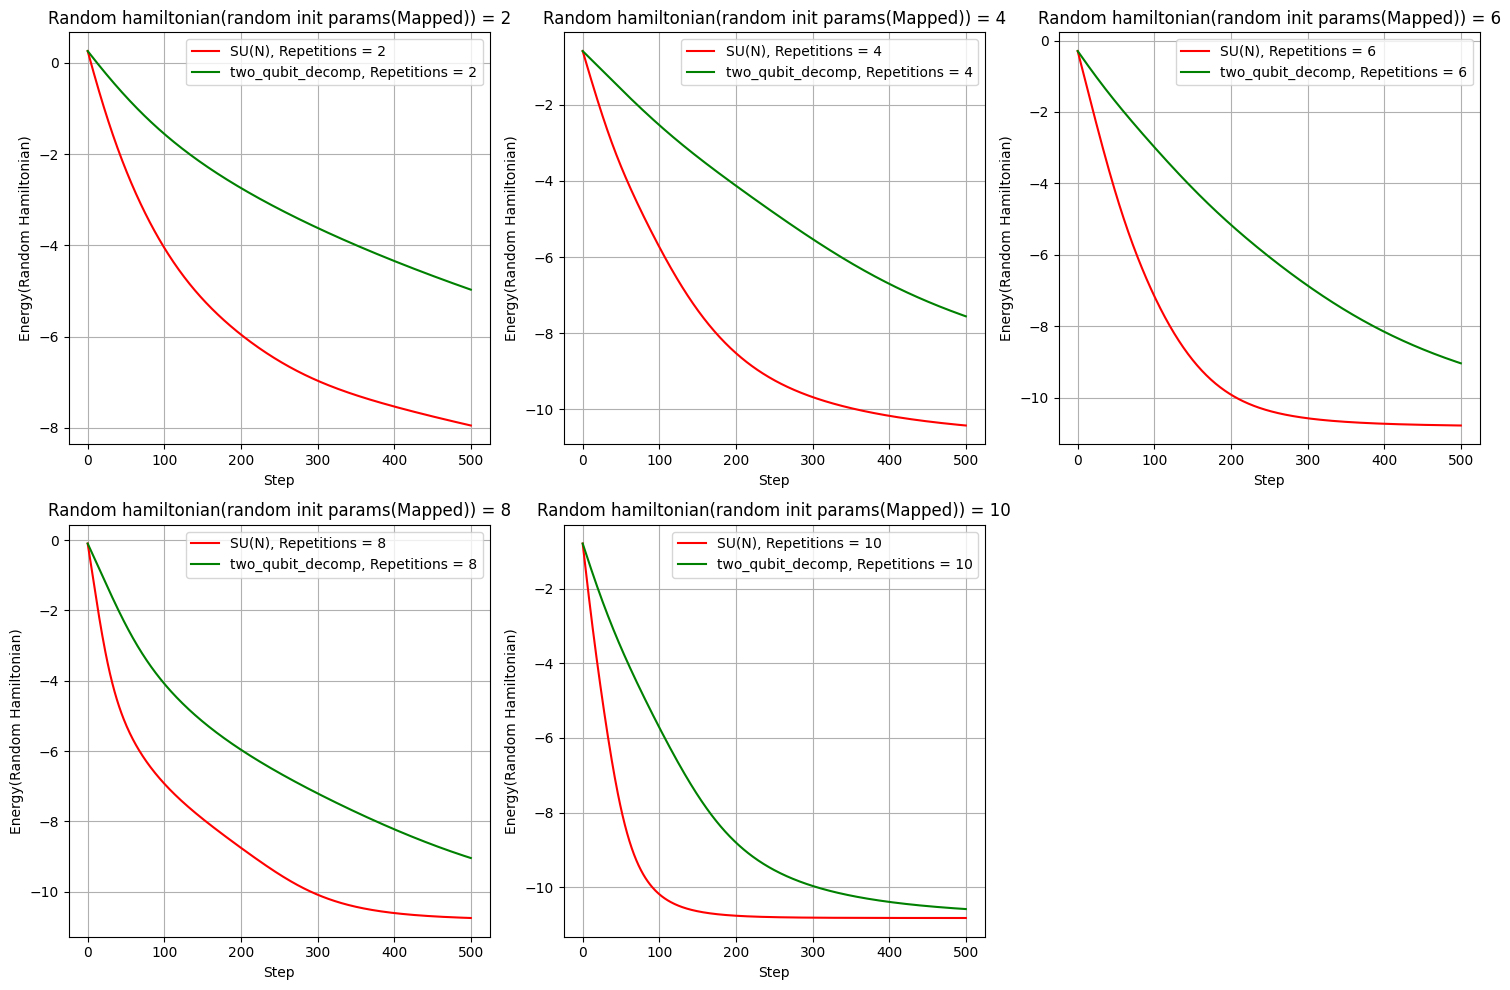

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Assuming the dictionaries dict1 and dict2 are already loaded and contain the necessary data

# Define the number of steps to restrict to 600
restricted_steps = 500

# Create the subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Loop over repetitions and create subplots
for i, rep in enumerate(repetitions):
    if i < len(axes):  # Ensure there are enough subplots
        ax = axes[i]
        
        # Plot data from dict1
        ax.plot(np.arange(restricted_steps + 1), dict1[rep][:restricted_steps + 1], color="red", label=f"SU(N), Repetitions = {rep}")
        
        # Plot data from dict2
        ax.plot(np.arange(restricted_steps + 1), dict2[rep][:restricted_steps + 1], color="green", label=f"two_qubit_decomp, Repetitions = {rep}")
        
        # Set plot title and labels
       # ax.set_yscale('log')
        ax.set_title(f"Random hamiltonian(random init params(Mapped)) = {rep}")
        ax.set_xlabel("Step")
        ax.set_ylabel("Energy(Random Hamiltonian)")
        #ax.set_ylabel("Relative Error (log Scale)")
        ax.legend()
        ax.grid(True)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
# Plot the relative errors for Special Unitary operations
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i,rep in enumerate(repetitions):
    e = optimize(i,qml.SpecialUnitary)#qml.SpecialUnitary
    error = (e - E_min_noisy) / abs(E_min_noisy)

    color = plt.cm.plasma(i / len(repetitions))  # Get color from a colormap
    plt.plot(np.arange(num_steps+1), error, color=color, label=f"Circuit Repetitions = {rep}")  # Label each curve
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title("Energy for SU Operations (Heisenberg Model - 4 Qubits)")
plt.xlabel("Step")
plt.ylabel("Relative Error (log scale)")
plt.legend()
plt.grid(True)
plt.show()
